In [2]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install seaborn

     |████████████████████████████████| 285 kB 13.1 MB/s 


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Path to save the figures and data files
PROJECT_ROOT_DIR = "Result"
FIGURE_ID = "Result/FigureFiles"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)
    
if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)
    
def image_path (fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')
    
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model)**2)/np.sum((y_data - np.mean(y_data))**2)

def MSE(y_data, y_model):
    n = np.size(y_model)
    return np.sum((y_data - y_model)**2/n)

### This exercise has as its aim to write a small program which reads in data from a csv file on the equation of state for dense nuclear matter. The file is localized at https://github.com/mhjensen/MachineLearningMSU-FRIB2020/blob/master/doc/pub/Regression/ipynb/datafiles/EoS.csv. 
### Thereafter you will have to set up the design matrix X for the n datapoints and a polynomial of degree 3
### The steps are:
     Write a Python code which reads the in the above mentioned file.
     Use for example pandas to order your data and find out how many data points there are.
     Set thereafter up the design matrix with dimensionality n×p where p=4 and where you have defined a polynomial of degree p−1=3. 
### Print the matrix and check that the numbers are correct.

/tmp/ipykernel_17476/526668024.py:41: RuntimeWarning: divide by zero encountered in log10
  plt.plot(polynomial, np.log10(train_error), label='Training Error')
/tmp/ipykernel_17476/526668024.py:42: RuntimeWarning: divide by zero encountered in log10
  plt.plot(polynomial, np.log10(test_error), label='Test Error')


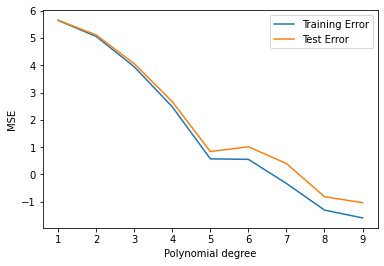

Mean squared error: 0.03
Variance score: 1.00
Mean absolute error: 0.14
[    0.            31.53723417  -384.18857047  3007.46118025
 -5815.91859423  9516.40389447 -9591.73310431  5868.38181568
 -1483.49568881     0.        ] -0.7824130531837454
Mean squared error: 13.12
Variance score: 1.00
Mean absolute error: 2.45
[  0.          62.58603534 205.83104651 258.89359022 257.72023551
 222.07319891 157.9609163   63.9086178  -66.31610551   0.        ] -15.767531280886033


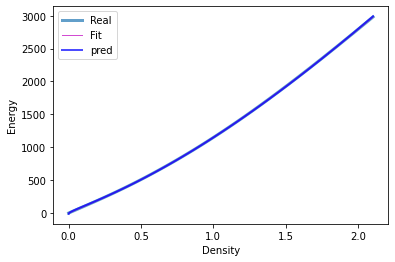

In [13]:
url = "https://raw.githubusercontent.com/mhjensen/MachineLearningMSU-FRIB2020/master/doc/pub/Regression/ipynb/datafiles/EoS.csv"
data = pd.read_csv(url, names=('Density', 'Energy'))
data['Energy'] = pd.to_numeric(data['Energy'], errors='coerce')
data = data.dropna()
density = data['Density']
energy = data['Energy']
data.tail(20)

max_polydegree = 10

X = np.zeros((len(density), max_polydegree))
X[:, 0] = 1.0

polynomial = np.zeros(max_polydegree)
test_error = np.zeros(max_polydegree)
train_error = np.zeros(max_polydegree)

for polydegree in range(1, max_polydegree):
    polynomial[polydegree] = polydegree
    test_error[polydegree] = 0
    train_error[polydegree] = 0
    
    for degree in range(polydegree):
        X[:,degree] = density**(degree/3)

    for sample in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, energy, test_size=0.2)

        # matrix inversion to find beta
        # beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
        # print(beta)
        model = skl.LinearRegression(fit_intercept=True).fit(X_train, y_train)
        y_tilde = model.predict(X_train)
        y_prediction = model.predict(X_test)
        test_error[polydegree] += MSE(y_test, y_prediction)
        train_error[polydegree] += MSE(y_train, y_tilde)

    test_error[polydegree] /= 100
    train_error[polydegree] /= 100

plt.plot(polynomial, np.log10(train_error), label='Training Error')
plt.plot(polynomial, np.log10(test_error), label='Test Error')
plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.legend()
plt.show()    

# use Scikitlearn linear regression and ridge regression
clf = skl.LinearRegression().fit(X, energy)
ytilde = clf.predict(X)
data['E_OLS'] = ytilde
# The mean squared error                               
print("Mean squared error: %.2f" % mean_squared_error(energy, ytilde))
# Explained variance score: 1 is perfect prediction                                 
print('Variance score: %.2f' % r2_score(energy, ytilde))
# Mean absolute error                                                           
print('Mean absolute error: %.2f' % mean_absolute_error(energy, ytilde))
print(clf.coef_, clf.intercept_)

# ridge regression with hyperparameter lambda = 0.1
_lambda = 0.1
clf_ridge = skl.Ridge(alpha=_lambda).fit(X, energy)
yridge = clf_ridge.predict(X)
data['E_ridge'] = yridge
# The mean squared error                               
print("Mean squared error: %.2f" % mean_squared_error(energy, yridge))
# Explained variance score: 1 is perfect prediction                                 
print('Variance score: %.2f' % r2_score(energy, yridge))
# Mean absolute error                                                           
print('Mean absolute error: %.2f' % mean_absolute_error(energy, yridge))
print(clf_ridge.coef_, clf_ridge.intercept_)

data['Eapprox'] = pd.Series(y_tilde)
data['prediction'] = pd.Series(y_prediction)

# Generate a plot comparing the experimental with the fitted values.
fig, ax = plt.subplots()
ax.set_xlabel('Density')
ax.set_ylabel('Energy')
ax.plot(data['Density'], data['Energy'], alpha=0.7, lw=3, label='Real')
ax.plot(data['Density'], data['E_OLS'], alpha=0.7, lw=1, label='Fit', c='m')
ax.plot(data['Density'], data['E_ridge'], alpha=0.7, lw=2, label='pred', c='b')
ax.legend()
plt.show()

In [9]:
x = np.random.rand(100)
y = 2.0+5*x*x+0.1*np.random.randn(100,1)

X = np.zeros((len(x), 3))
X[:,0] = 1.0
X[:,1] = x
X[:,2] = x**2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

y_tilde = X_train @ beta
y_prediction = X_test @ beta


In [10]:
print(R2(y_train, y_tilde))
print(MSE(y_train, y_tilde))
print(R2(y_test, y_prediction))
print(MSE(y_test, y_prediction))


0.9953183672205697
0.010837171305872435
0.997333414489145
0.006152979108978411


      A  Z   N Element      Energy  NeutronSeparationEnergy
41   12  8   4       O   58.682424                      NaN
47   13  8   5       O   75.552919                16.870495
52   14  8   6       O   98.731892                23.178973
58   15  8   7       O  111.955380                13.223488
65   16  8   8       O  127.619296                15.663916
71   17  8   9       O  131.762376                 4.143080
78   18  8  10       O  139.807746                 8.045370
85   19  8  11       O  143.763405                 3.955659
93   20  8  12       O  151.371400                 7.607995
101  21  8  13       O  155.176854                 3.805454
109  22  8  14       O  162.027162                 6.850308
118  23  8  15       O  164.760155                 2.732993
126  24  8  16       O  168.952440                 4.192285
135  25  8  17       O  168.195125                -0.757315
143  26  8  18       O  168.934428                 0.739303


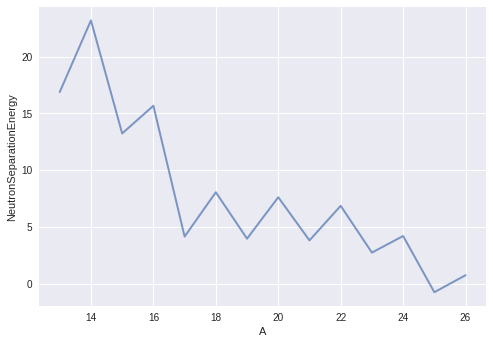

In [20]:
# write your own code (you can use the example the nuclear masses 
# in the lecture slides on Regression and Getting started from Day1, 
# that reads in the nuclear masses and compute the proton separation energies, 
# the two-neutron and two-proton separation energies 
# and finally the shell gaps for selected nuclei.
# compute the Q-values for β− decay for selected nuclei.

plt.style.use('seaborn')

url = 'https://raw.githubusercontent.com/NuclearTalent/MachineLearningECT2021/gh-pages/doc/src/Day1/datafiles/MassEval2016.dat'
Masses = pd.read_fwf(url, usecols=(2,3,4,6,11), 
                     names=('N', 'Z', 'A', 'Element', 'Ebinding'), 
                     widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
                     header=39, index_col=False)

Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
Masses['Ebinding'] /= 1000

A = Masses['A']
N = Masses['N']
Z = Masses['Z']
Element = Masses['Element']
Energy = Masses['Ebinding'] * A

df = pd.DataFrame({'A':A, 'Z':Z, 'N':N, 'Element':Element, 'Energy':Energy})

# Calculate Q-values for Oxygen 
Nucleus = df.loc[lambda df: df.Z==8, :]
Nucleus = Nucleus.dropna()
Nucleus['NeutronSeparationEnergy'] = Nucleus['Energy'].diff(+1)
print(Nucleus)

fig, ax = plt.subplots()
ax.set_xlabel('A')
ax.set_ylabel('NeutronSeparationEnergy')
ax.plot(Nucleus['A'], Nucleus['NeutronSeparationEnergy'], alpha=0.7, lw=2, label='Real')
save_fig('Nucleus')
plt.show()